# MNIST Autoencoder + GAN

In this notebook a regular autoencoder was implemented that achieves a decent image reconstruction. Furthermore, the autoencoder was added to the GAN network of Alexander in order to find out if it makes a difference.

Ultimately, the training was more successful without the structured noise.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers 

ENC_FILENAME = "/encoder.h5"
DEC_FILENAME = "/decoder.h5"
AUT_FILENAME = "/autoencoder.h5"

In [2]:
class VAE:
    E_LAST_LAYER = "latent_layer"

    D_FIRST_LAYER = "decoder"
    D_LAST_LAYER = "decoder_reshape"

    def build_encoder(self):
        self.encoder = keras.Sequential([
            keras.layers.Flatten(input_shape=self.shape),
            keras.layers.Dense(800),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(400),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(200),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(100),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(self.latent_space_size),
            keras.layers.LeakyReLU()
        ])

        if self.summary:
            print("###########")
            print("# ENCODER #")
            print("###########")
            print(self.encoder.summary())

    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.Dense(64, input_shape = (self.latent_space_size,)),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(100),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(200),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(400),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(784),
            keras.layers.Activation("sigmoid"),
            keras.layers.Reshape(self.shape)
        ])

        if self.summary:
            print("###########")
            print("# DECODER #")
            print("###########")
            print(self.decoder.summary())

    def __init__(self, shape, latent_space_size, summary=False):
        self.shape = shape
        self.latent_space_size = latent_space_size
        self.summary = summary

        self.build_encoder()
        self.build_decoder()

        img = keras.Input(shape = self.shape)
        latent_vector = self.encoder(img)
        output = self.decoder(latent_vector)

        self.autoencoder = keras.Model(inputs = img, outputs = output)

        if self.summary:
            print("###############")
            print("# AUTOENCODER #")
            print("###############")
            print(self.autoencoder.summary())

        self.autoencoder.compile("nadam", loss="binary_crossentropy")

    def import_models(self, path, force=False, compile=True):
        root = Path(path)

        if not root.exists():
            if force:
                raise ValueError(f"directory {path} does not exist")
            else:
                return

        enc = Path(path+ENC_FILENAME)
        dec = Path(path+DEC_FILENAME)
        aut = Path(path+AUT_FILENAME)

        if not enc.exists():
            if force:
                raise ValueError(f"file {enc} does not exist")
            else:
                return
        if not dec.exists():
            if force:
                raise ValueError(f"file {dec} does not exist")
            else:
                return
        if not aut.exists():
            if force:
                raise ValueError(f"file {aut} does not exist")
            else:
                return

        self.encoder = keras.models.load_model(str(enc), compile=compile)
        self.decoder = keras.models.load_model(str(dec), compile=compile)
        self.autoencoder = keras.models.load_model(str(aut), compile=compile)

    def export(self, path):
        root = Path(path)

        if not root.exists():
            root.mkdir(parents=True, exist_ok=True)

        self.encoder.save(os.path.normpath(path + ENC_FILENAME))
        self.decoder.save(os.path.normpath(path + DEC_FILENAME))
        self.autoencoder.save(os.path.normpath(path + AUT_FILENAME))

    def train(self, training_data, testing_data, epochs=10, batch_size=256):
        self.autoencoder.fit(
            training_data, training_data,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(testing_data, testing_data),
        )

In [3]:
def load_prepared_data():
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), 28, 28, 1))

    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape((len(x_test), 28, 28, 1))

    return (x_train, x_test)


def show_sample(sample):
    plt.imshow(sample)
    plt.colorbar()
    plt.show()


def visualize(vae):
    (_, x_test) = load_prepared_data()

    decoded_imgs = vae.autoencoder.predict(x_test)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


def train(vae):
    (x_train, x_test) = load_prepared_data()
    vae.train(x_train, x_test, 128, 256)
    vae.export("gan/degan/vae")


def test():
    (x_train, _) = load_prepared_data()

    show_sample(x_train[0].reshape(28, 28))

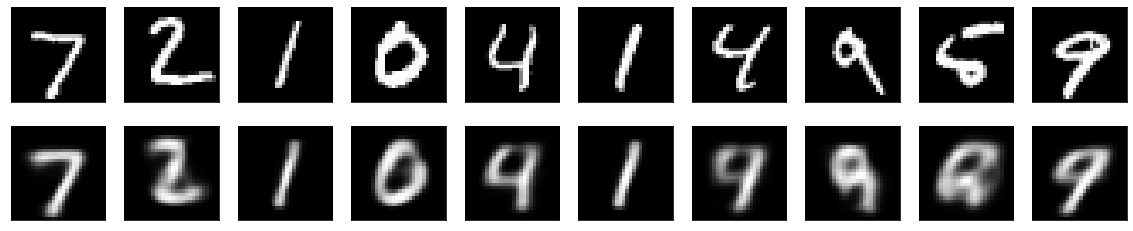

In [7]:
# map the MNIST images (28x28 with only 1 channel) to a space of 100 floats
vae = VAE((28, 28, 1), 100, summary=False)
vae.import_models("../gan/models/mnist/degan/ae2")

# train(vae)
visualize(vae)

# vae.export("../gan/models/mnist/degan/ae2")

In [14]:
# python style of importing from parent folder
import sys
sys.path.append('../')

from gan import GAN

class DEGAN_MNIST(GAN):
    def __init__(self, ae, use_ae=True, path='../gan/models/mnist/degan-without-ae/', show_training_results=True):
        super().__init__(path=path, show_training_results=show_training_results)
        self.ae = ae
        self.use_ae = use_ae

    def sample_noise(self, batch_size, noise_shape):
        noise = super().sample_noise(batch_size, noise_shape)

        decoded = self.ae.decoder(noise)
        encoded = self.ae.encoder(decoded)

        if self.use_ae:
            return encoded
        else:
            return noise
    
    def build_generator(self):
        noise_shape = (self.get_noise_dim(),)
        
        model = keras.Sequential([

            # project and reshape
            layers.Dense(7*7*128, use_bias=False, input_shape=noise_shape),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Reshape((7, 7, 128)),
            # shape (7, 7, 128)

            # stride 2 -> larger image
            # thiccness 64 -> channels
            layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            # shape (14, 14, 64)

            layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
            # shape (28, 28, 1)

        ])

        return model
    
    def build_discriminator(self):
        img_shape = (28, 28, 1)
        
        model = keras.Sequential([

            layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=img_shape),
            layers.LeakyReLU(alpha=.2),
            # shape (14, 14, 64)

            layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=.2),
            # shape (7, 7, 128)

            layers.Flatten(),
            layers.Dense(1) #, activation='sigmoid')
            # FIXME when using sigmoid as proposed by the paper the classification does not work.
            # somehow the  two classes (real/fake) cannot be differentiated
            # I assume this has to do with sigmoid being independent between classes (and real/fake being not)
            # https://gombru.github.io/2018/05/23/cross_entropy_loss/
        ])
        
        return model

    def get_noise_dim(self):
        return 100

    def get_optimizers(self):
        d = tf.keras.optimizers.Adam(.0002, .5) 
        g = tf.keras.optimizers.Adam(.0002, .5) 
        return (d, g)

epoch 1
(128, 100)
(128, 100)
(112, 100)


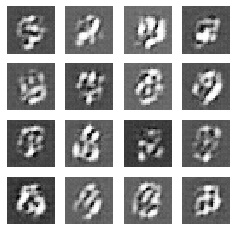

epoch 2


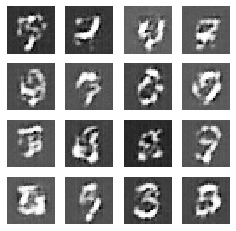

epoch 3


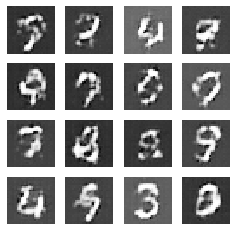

epoch 4


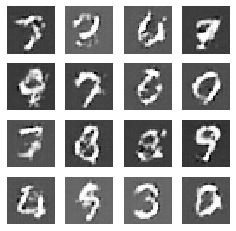

epoch 5


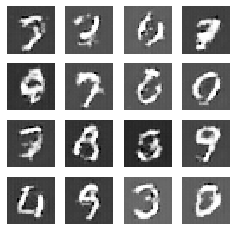

epoch 6


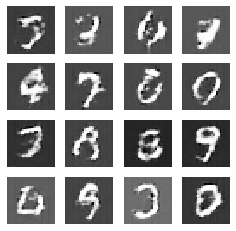

epoch 7


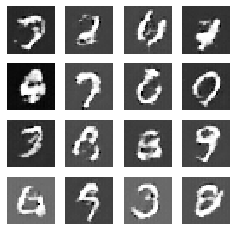

epoch 8


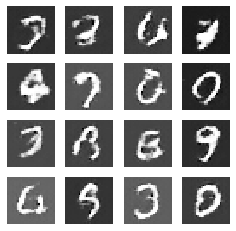

epoch 9


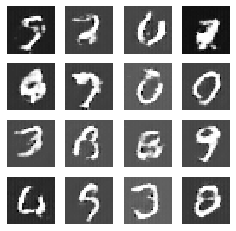

epoch 10


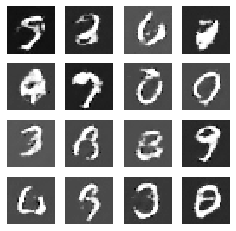

epoch 11


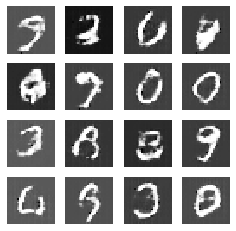

epoch 12


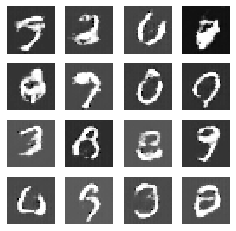

epoch 13


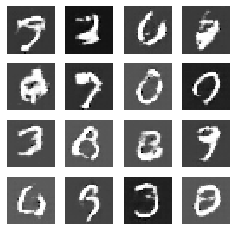

epoch 14


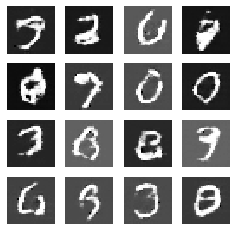

epoch 15


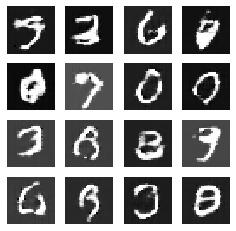

epoch 16


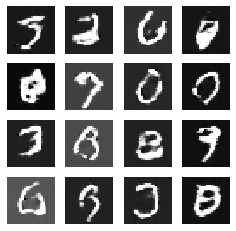

epoch 17


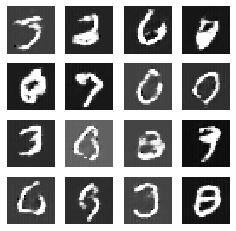

epoch 18


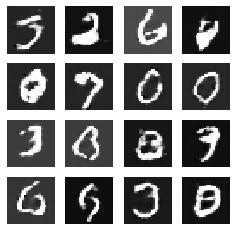

epoch 19


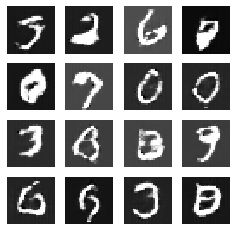

epoch 20


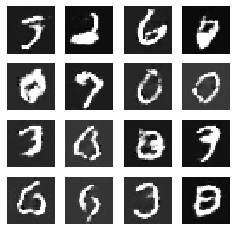

epoch 21


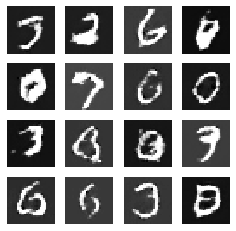

epoch 22


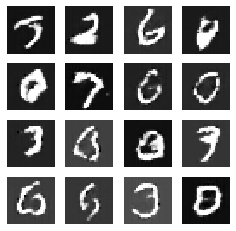

epoch 23


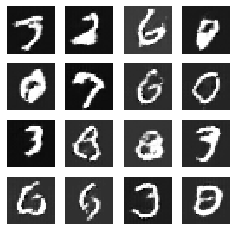

epoch 24


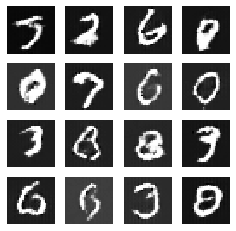

epoch 25


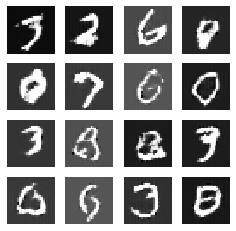

epoch 26


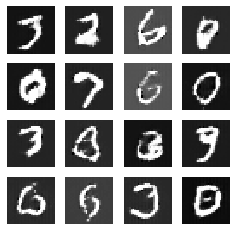

epoch 27


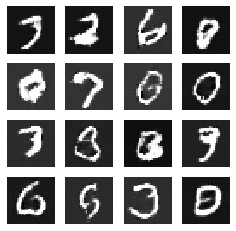

epoch 28


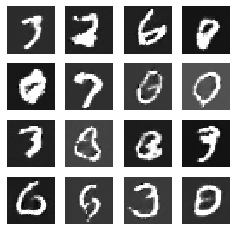

epoch 29


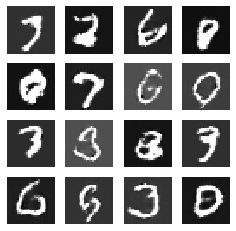

epoch 30


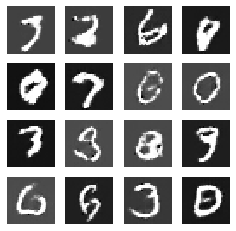

epoch 31


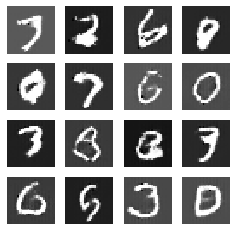

epoch 32


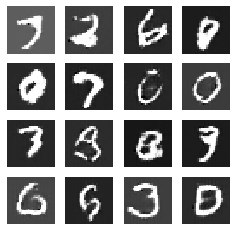

epoch 33


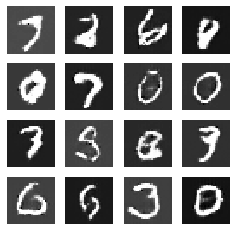

epoch 34


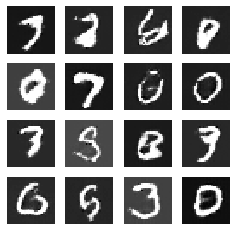

epoch 35


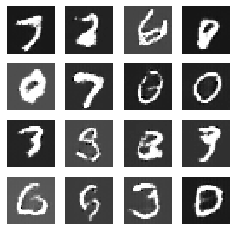

epoch 36


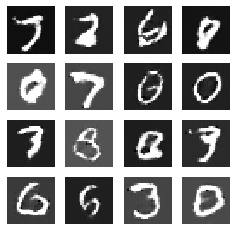

epoch 37


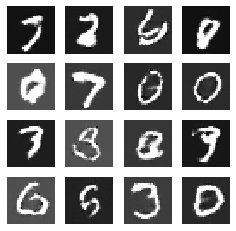

epoch 38


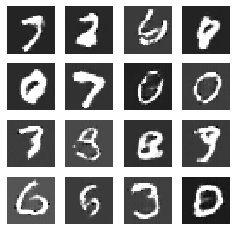

epoch 39


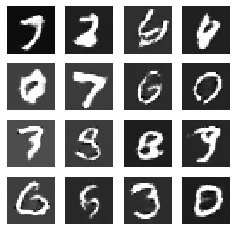

epoch 40


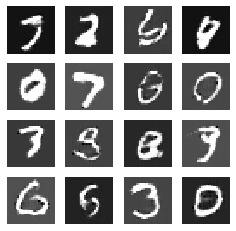

epoch 41


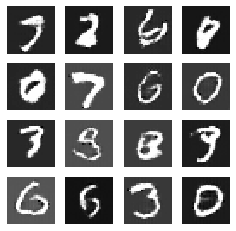

epoch 42


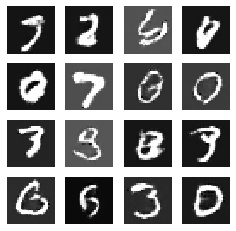

epoch 43


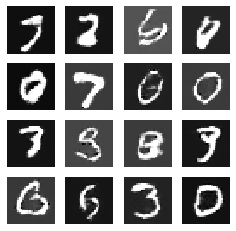

epoch 44


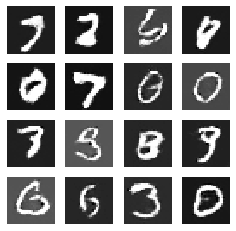

epoch 45


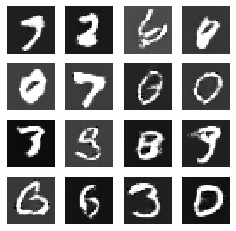

epoch 46


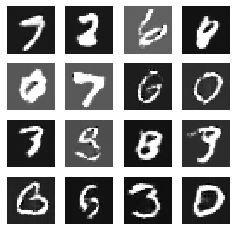

epoch 47


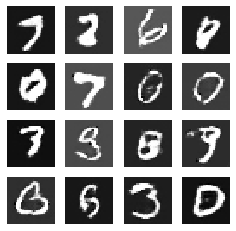

epoch 48


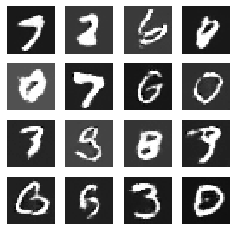

epoch 49


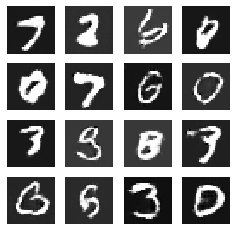

epoch 50


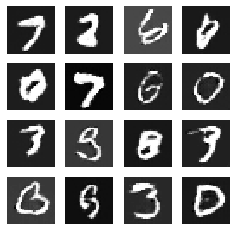

In [15]:
from herold.mnist import MNIST_provider

epochs = 50
provider = MNIST_provider(128)
gan = DEGAN_MNIST(vae, use_ae=False)

gan.set_training_data(provider.get_numbers)

for epoch in range(epochs):
    
    print(f"epoch {epoch+1}")
    
    i = 1
    # start training
    for image_batch in provider.get_numbers():
        # print(f"batch {i}")
        gan.train_step(image_batch)
        i += 1

    gan._generate_and_save_images(gan.generator, epoch, gan.seed)
    # end training

gan.export()
# gan.generate_gif()